Obiettivo:

raggruppare i Paesi in base a fattori socio-economici e sanitari che determinano lo sviluppo complessivo del Paese.

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

import plotly.express as px

import kaleido

In [185]:
data = pd.read_csv('Country-data.csv')

Non ci sono valori nulli

Alcune caratteristiche appartengono essenzialmente alla stessa categoria

Le 3 categorie di caratteristiche sono :
- salute : mortalità_infantile, salute, vita_espec, totale_fer
- commercio: importazioni, esportazioni
- finanza : reddito, inflazione, PIL

Di conseguenza, riduco queste caratteristiche in queste categorie e le normalizzo

In [186]:
df1 = pd.DataFrame()
df1['Health'] = (data['child_mort'] / data['child_mort'].mean()) + (data['health'] / data['health'].mean()) + (data['life_expec'] / data['life_expec'].mean()) + (data['total_fer'] / data['total_fer'].mean())
df1['Trade'] = (data['imports'] / data['imports'].mean()) + (data['exports'] / data['exports'].mean())
df1['Finance'] = (data['income'] / data['income'].mean()) + (data['inflation'] / data['inflation'].mean()) + (data['gdpp'] / data['gdpp'].mean())
df1.head()

,Health,Trade,Finance
0,6.24,1.20,1.35
1,3.04,1.72,1.47
2,3.39,1.60,3.17
3,6.47,2.43,3.49
4,2.96,2.36,2.24


In [187]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler() # Normalization

df1['Health'] = mms.fit_transform(df1[['Health']])
df1['Trade'] = mms.fit_transform(df1[['Trade']])
df1['Finance'] = mms.fit_transform(df1[['Finance']])
df1.insert(loc = 0, value = list(data['country']), column = 'Country')
df1.head()

,Country,Health,Trade,Finance
0,Afghanistan,0.63,0.14,0.08
1,Albania,0.13,0.20,0.09
2,Algeria,0.18,0.19,0.21
3,Angola,0.66,0.28,0.24
4,Antigua and Barbuda,0.12,0.28,0.15


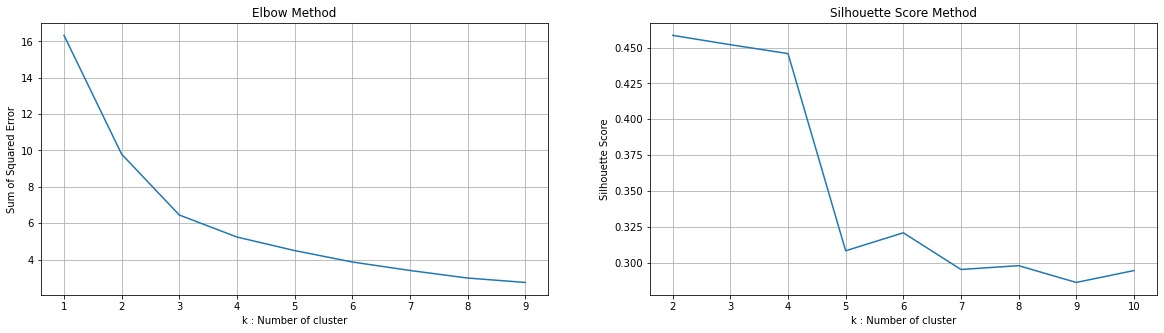

In [188]:
import warnings
warnings.filterwarnings('ignore')

m1 = df1.drop(columns = ['Country']).values # k-means non usa feature nominali

sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(m1)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

sns.lineplot(x = list(sse.keys()), y = list(sse.values()));
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")
plt.grid()

# Silhouette Score Method
plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k).fit(m1)
    labels = kmeans.labels_
    sil.append(silhouette_score(m1, labels, metric = 'euclidean'))
sns.lineplot(x = range(2,kmax + 1), y = sil);
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Silhouette Score")
plt.grid()

plt.show()

Quindi seleziono k=3

In [189]:
model = KMeans(n_clusters = 3,max_iter = 1000)
model.fit(m1)
cluster = model.cluster_centers_
centroids = np.array(cluster)
labels = model.labels_
data['Class'] = labels; df1['Class'] = labels

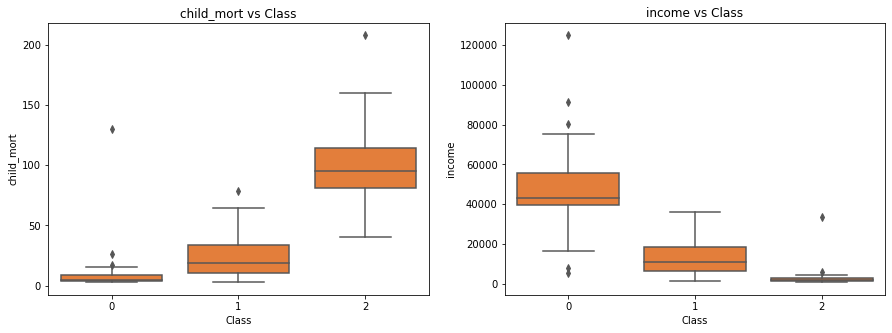

In [190]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'Class', y = 'child_mort', data  = data, color = '#FF781F');
plt.title('child_mort vs Class')

plt.subplot(1,2,2)
sns.boxplot(x = 'Class', y = 'income', data  = data, color = '#FF781F');
plt.title('income vs Class')

plt.show()

In [191]:
df1['Class'].loc[df1['Class'] == 0] = 'No Help Needed'
df1['Class'].loc[df1['Class'] == 1] = 'Might Need Help'
df1['Class'].loc[df1['Class'] == 2] = 'Help Needed'

fig = px.choropleth(df1[['Country','Class']],
                    locationmode = 'country names',
                    locations = 'Country',
                    title = 'Needed Help Per Country (World)',
                    color = df1['Class'],  
                    color_discrete_map = {'Help Needed':'Red',
                                        'No Help Needed':'Green',
                                        'Might Need Help':'Yellow'}
                   )
fig.update_geos(fitbounds = "locations", visible = True)
fig.update_layout(legend_title_text = 'Labels',legend_title_side = 'top',title_pad_l = 260,title_y = 0.86)
fig.show(engine = 'kaleido')